# Анализ данных клиентов сервиса аренды самокатов. 
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться

:
Предоставлено три файлы описывающие поведение клиентов сервиса аренды самокатов.
Сервис имеет два варианта аренды самокатов.
### без подписки
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;
### с подпиской Ultra
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.
### Файлы
### Пользователи — users_go.csv
- user_id	уникальный идентификатор пользователя
- name	имя пользователя
- age	возраст
- city	город
- subscription_type	тип подписки (free, ultra)

### Поездки — rides_go.csv
- user_id	уникальный идентификатор пользователя
- distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date	дата совершения поездки

### Подписки — subscriptions_go.csv
- subscription_type	тип подписки
- minute_price	стоимость одной минуты поездки по данной подписке
- start_ride_price	стоимость начала поездки
- subscription_fee	стоимость ежемесячного платежа

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp
from scipy.stats import binom
from scipy import stats as st
from scipy.stats import norm

#### Шаг 1. Загрузка данных

In [32]:
users_go_data = pd.read_csv('users_go.csv')
rides_go_data = pd.read_csv('rides_go.csv')
subscriptions_go_data = pd.read_csv('subscriptions_go.csv')

display(users_go_data.head(5))
display(rides_go_data.head(5))
display(subscriptions_go_data.head(5))
users_go_data.info()
rides_go_data.info()
subscriptions_go_data.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Col

#### Шаг 2. Предобработка данных

In [33]:
rides_go_data['date'] = pd.to_datetime(rides_go_data['date'], errors='coerce')
rides_go_data['month_number'] = rides_go_data['date'].dt.month
min_date = rides_go_data['date'].min()
max_date = rides_go_data['date'].max()
print(f'Диапазон дат: от {min_date} до {max_date}')
print(rides_go_data[['month_number', 'date']].head(10))

Диапазон дат: от 2021-01-01 00:00:00 до 2021-12-30 00:00:00
   month_number       date
0             1 2021-01-01
1             1 2021-01-18
2             4 2021-04-20
3             8 2021-08-11
4             8 2021-08-28
5            10 2021-10-09
6            10 2021-10-19
7            11 2021-11-06
8            11 2021-11-14
9            11 2021-11-22


Датасет включает в себя информацию за один год (2021).

In [34]:
def check_duplicates(df, name):
    dup_count = df.duplicated().sum()
    print(f"В {name}: {dup_count} дубликатов")
    if dup_count > 0:
        print(df[df.duplicated()].head())
    print('-' * 50)

In [35]:
users_go_data_missing_values = users_go_data.isnull().sum()
users_go_data_missing_values = users_go_data_missing_values[users_go_data_missing_values > 0].sort_values(ascending=False)
users_go_data_missing_values
check_duplicates(users_go_data, "users_go_data")
users_go_data = users_go_data.drop_duplicates()

В users_go_data: 31 дубликатов
      user_id        name  age          city subscription_type
1534      293       Агата   26     Краснодар             ultra
1535       16      Амалия   27     Краснодар             ultra
1536      909  Константин   20  Екатеринбург              free
1537      403      Полина   19          Сочи             ultra
1538      908      Рустам   30        Тюмень              free
--------------------------------------------------


В файле users_go_data обнаружено 31 дубликат. Решено их удалить для корректного анализа данных.

In [36]:
rides_go_data_missing_values = rides_go_data.isnull().sum()
rides_go_data_missing_values = rides_go_data_missing_values[rides_go_data_missing_values > 0].sort_values(ascending=False)
rides_go_data_missing_values
check_duplicates(rides_go_data, "rides_go_data")

В rides_go_data: 0 дубликатов
--------------------------------------------------


В файле rides_go_data дубликаты не найдены.

In [37]:
subscriptions_go_data_missing_values = subscriptions_go_data.isnull().sum()
subscriptions_go_data_missing_values = subscriptions_go_data_missing_values[subscriptions_go_data_missing_values > 0].sort_values(ascending=False)
subscriptions_go_data_missing_values
check_duplicates(subscriptions_go_data, "subscriptions_go_data")

В subscriptions_go_data: 0 дубликатов
--------------------------------------------------


В файле subscriptions_go_data дубликаты не найдены.

#### Шаг 3. Исследовательский анализ данных

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


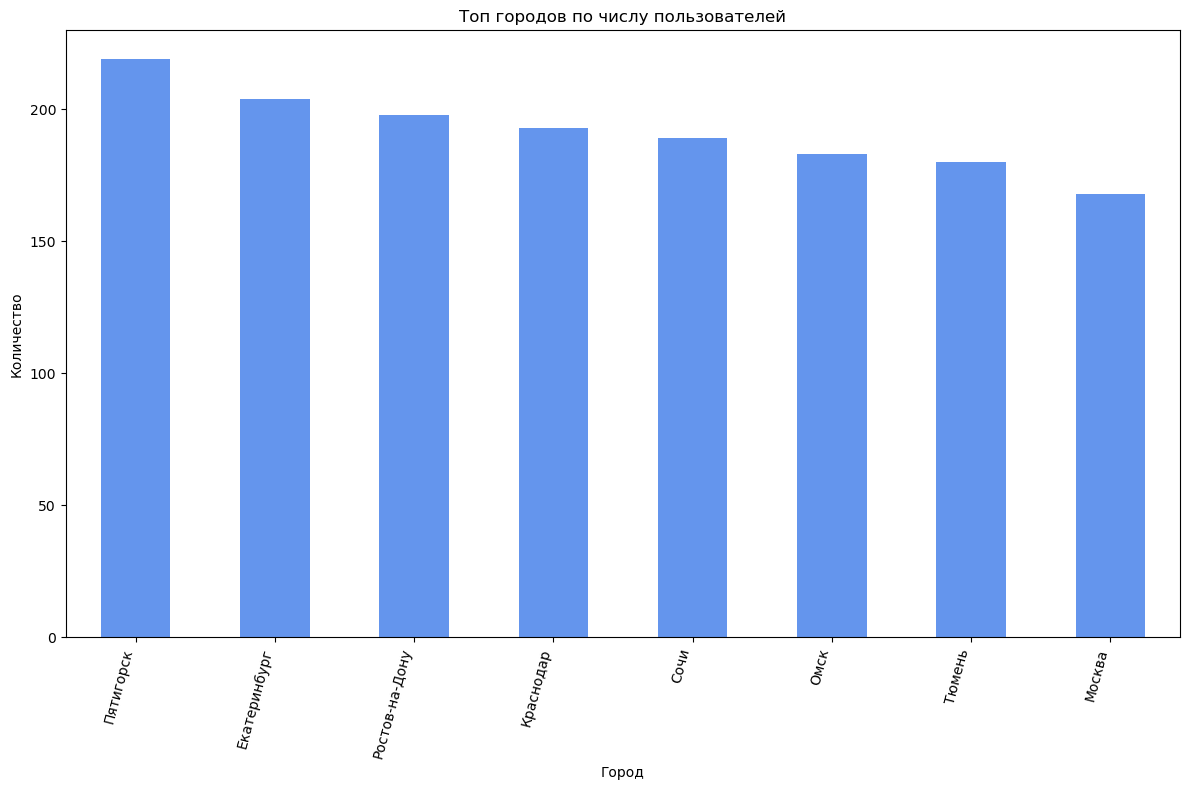

In [38]:
print(users_go_data['city'].value_counts(ascending=False).head(10))
top_cities = users_go_data['city'].value_counts(ascending=False).head(10)
plt.figure(figsize=(12, 8))
top_cities.plot(kind='bar', color='cornflowerblue')
plt.title('Топ городов по числу пользователей')
plt.xlabel('Город')
plt.ylabel('Количество')
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

В данном разделе описаны города где представлена компания. В тройку лидеров входят Пятигорск, Екатеринбург и Ростов-на-Дону. Стоит отметить что разброс между городами незначителен и разница между лидером списка (Пятигорск) и аутсайдером (Москва) не сильно выделяется.

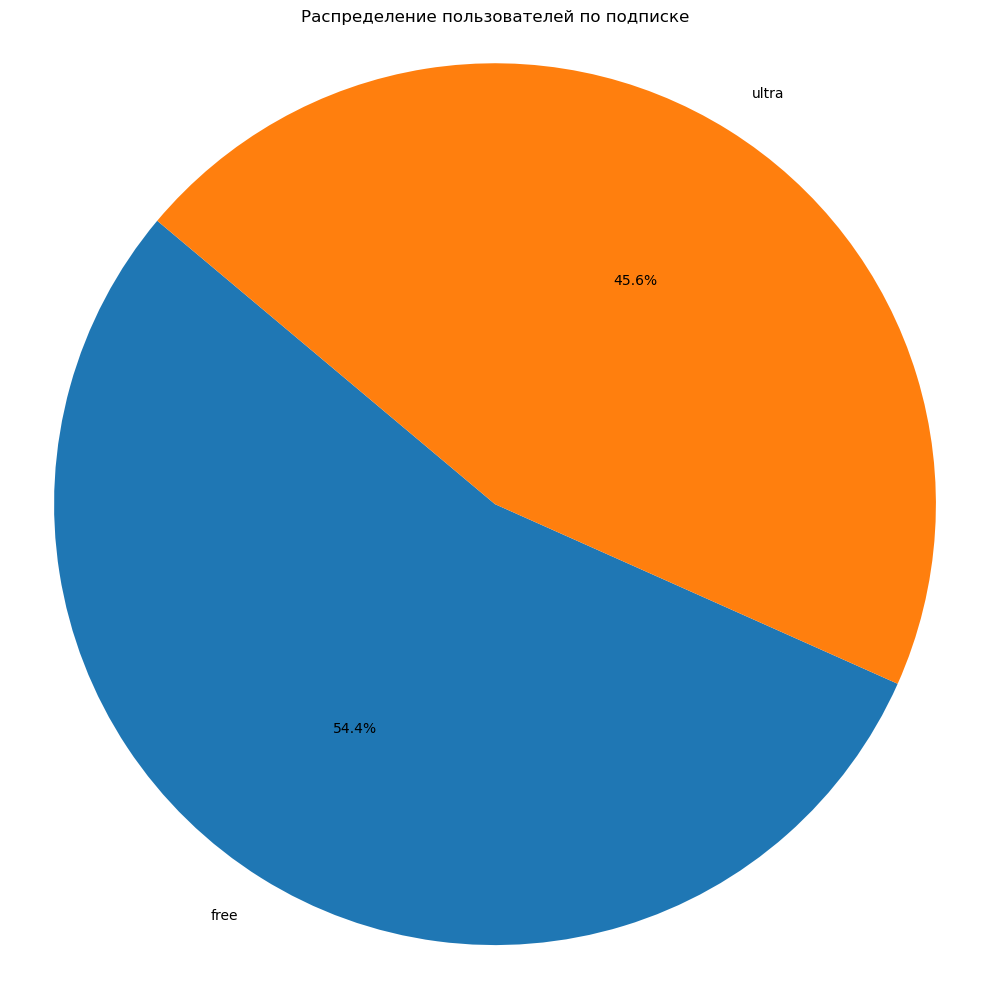

In [39]:
subscription_ratio = users_go_data['subscription_type'].value_counts(normalize=True)
plt.figure(figsize=(10, 10))
plt.pie(subscription_ratio, labels=subscription_ratio.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение пользователей по подписке')
plt.axis('equal')
plt.tight_layout()
plt.show()

Соотношение клиентов с подпиской и без примерно одинаковое, однако есть небольшое преобладание тез кто не покупает подписки (54,4%) против клиентов с подпиской (45,6%). Для анализа данных обе группы представлены одинаково, соответственно делать выборку что бы объективного анализа не требуется.

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


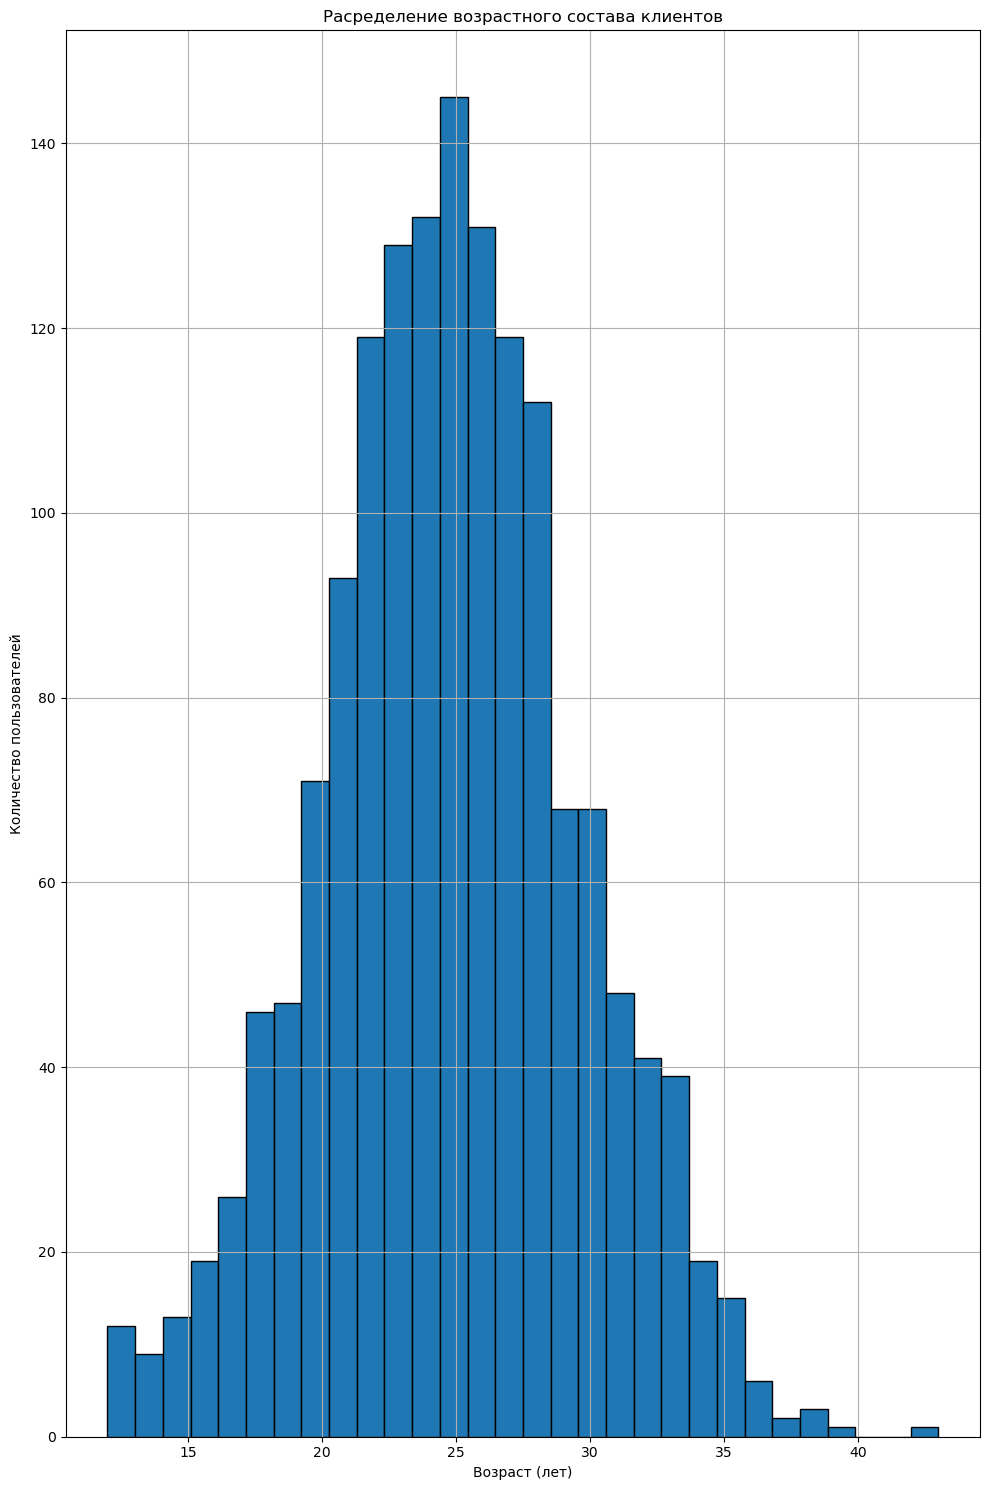

In [40]:
print(users_go_data['age'].describe())
users_go_data['age'].hist(figsize=(10, 15), bins=30, edgecolor='black')
plt.xlabel('Возраст (лет)')
plt.ylabel('Количество пользователей')
plt.title('Расределение возрастного состава клиентов')
plt.tight_layout()
plt.show()

Данная гистограмма описывает возрастной состав клиентов. Львиная доля клиентов это люди от 20 до 30 лет. Доля людей старше 30 или моложе 20 незначительна.

count    18068.000000
mean         3.070660
std          1.116831
min          0.000856
25%          2.543226
50%          3.133610
75%          3.776223
max          7.211008
Name: distance, dtype: float64


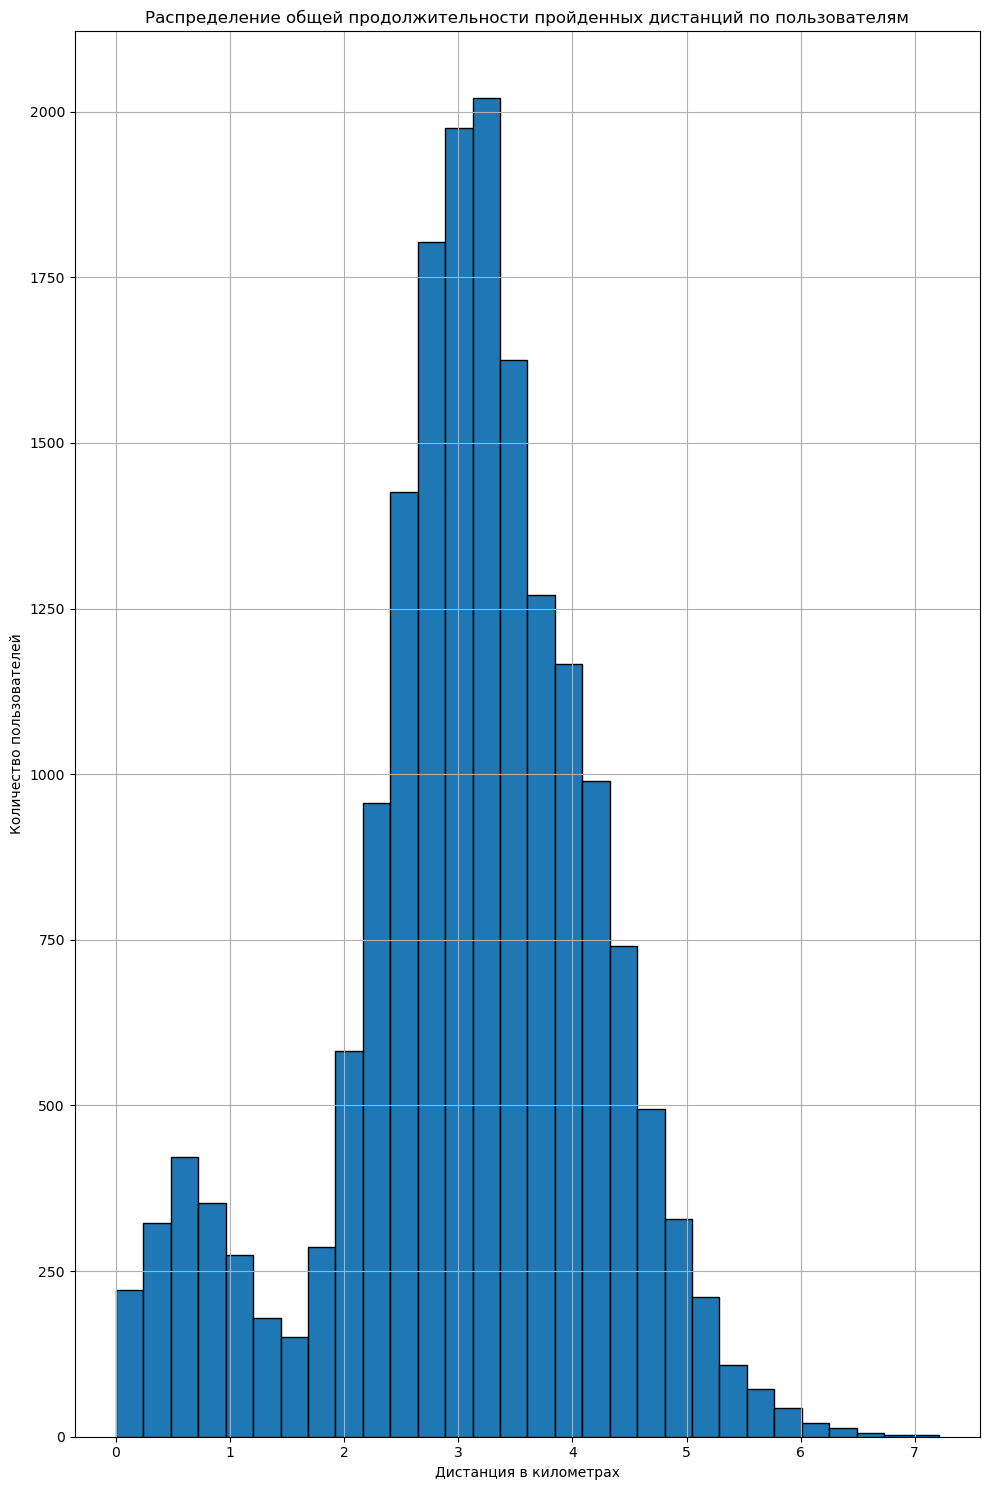

In [41]:
total_distance_per_user = rides_go_data['distance'] / 1000
print(total_distance_per_user.describe())
total_distance_per_user.hist(figsize=(10, 15), bins=30, edgecolor='black')
plt.xlabel('Дистанция в километрах')
plt.ylabel('Количество пользователей')
plt.title('Распределение общей продолжительности пройденных дистанций по пользователям')
plt.tight_layout()
plt.show()

Гистограмма показывает что клиенты разделены на две группы, одна небольшая группа использующие самокаты на дистанции от 500 метров до 1.5 км, и те кому нужен самокат для поездок на дистанции от 2 до 5 км которые составляют большинство клиентов.  

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


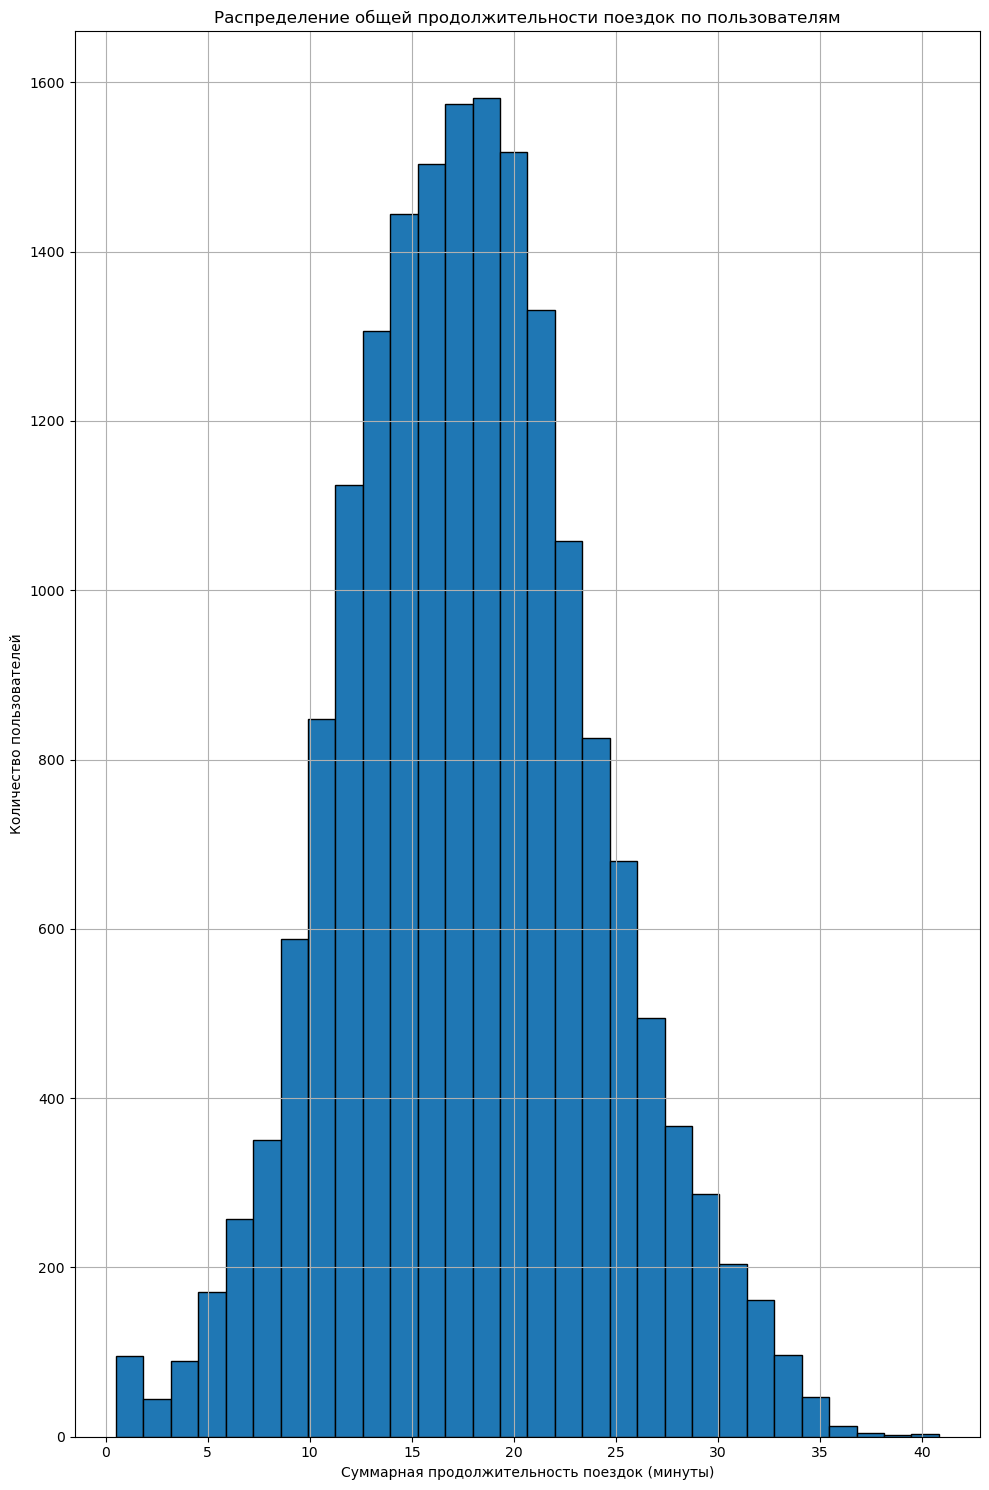

In [42]:
print(rides_go_data['duration'].describe())
rides_go_data['duration'].hist(figsize=(10, 15), bins=30, edgecolor='black')
plt.xlabel('Суммарная продолжительность поездок (минуты)')
plt.ylabel('Количество пользователей')
plt.title('Распределение общей продолжительности поездок по пользователям')
plt.tight_layout()
plt.show()

Среднее значение длительности поездок составило 17 минут. Большинство клиентов пользуются самокатами от 10 минут до 25 минут. 

#### Шаг 4. Объединение данных

In [43]:
merge_data = pd.merge(users_go_data, rides_go_data, on='user_id', how='outer')
merged_data_full = pd.merge(merge_data, subscriptions_go_data, how='outer')
print(merged_data_full.info())
print(merged_data_full.shape[0], 'Общее количество записей в датафрейме')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month_number       18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB
None
18068 Общее количество за

In [44]:
clients_with_subcripion = merged_data_full[merged_data_full['subscription_type'] == 'ultra']
print(clients_with_subcripion.info())
print(clients_with_subcripion.shape[0], 'Общее клиентов с подпиской')

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month_number       6500 non-null   int32         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 634.8+ KB
None
6500 Общее клиентов с подписко

In [45]:
clients_without_subcripion = merged_data_full[merged_data_full['subscription_type'] == 'free']
print(clients_without_subcripion.info())
print(clients_without_subcripion.shape[0], 'Общее клиентов без подписки')

<class 'pandas.core.frame.DataFrame'>
Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month_number       11568 non-null  int32         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.1+ MB
None
11568 Общее клиентов без по

Все три датасета были объедены в один файл с целью анализа данных и подтверждения гипотез. После объединения данные были отсортированы по критерию те кто оформил подписку (6.5 тыс записей) и те кто не оформил (11.5 тыс записей). Это позволит проанализировать и  визуализировать данные по переменным, пройденное расстояние и время. 

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


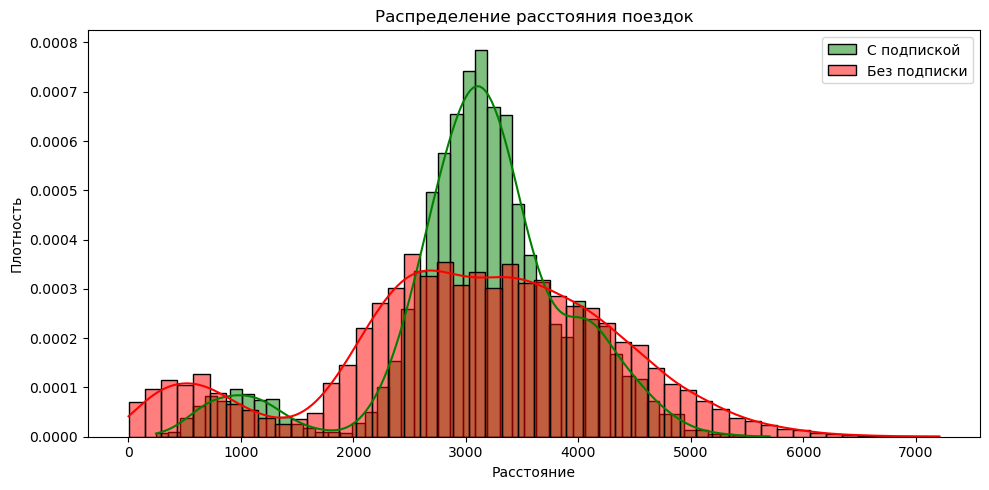

In [46]:
plt.figure(figsize=(10, 5))
sns.histplot(data=clients_with_subcripion, x='distance', color='green', label='С подпиской', kde=True, stat='density', bins=50)
sns.histplot(data=clients_without_subcripion, x='distance', color='red', label='Без подписки', kde=True, stat='density', bins=50)

plt.title('Распределение расстояния поездок')
plt.xlabel('Расстояние')
plt.ylabel('Плотность')
plt.legend()
plt.tight_layout()
plt.show()

- Пользователи без подписки чаще совершают очень короткие поездки (пик плотности около 0.0008 для малых расстояний).
- Пользователи с подпиской чаще выбирают средние дистанции (их кривая плотности более "плоская" и протяженная).

Интерпретация:
- Подписка, вероятно, делает длительные поездки более выгодными, поэтому пользователи реже ограничиваются короткими дистанциями.
- Без подписки поездки, скорее всего, оплачиваются пропорционально расстоянию, что мотивирует экономить на длинных маршрутах.

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


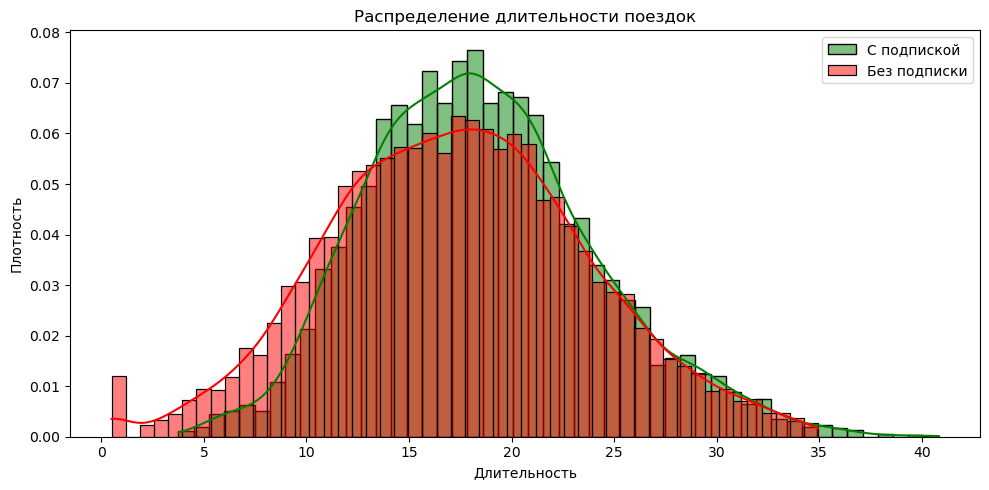

In [47]:
plt.figure(figsize=(10, 5))
sns.histplot(data=clients_with_subcripion, x='duration', color='green', label='С подпиской', kde=True, stat='density', bins=50)
sns.histplot(data=clients_without_subcripion, x='duration', color='red', label='Без подписки', kde=True, stat='density', bins=50)

plt.title('Распределение длительности поездок')
plt.xlabel('Длительность')
plt.ylabel('Плотность')
plt.legend()
plt.tight_layout()
plt.show()

Сравнение длительности поездок двух групп показало что клиенты с подпиской пользуются самокатами значительно чаще чем клиенты без подписок.

#### Шаг 5. Подсчёт выручки

5.1

In [48]:
merged_data_full['duration'] = np.ceil(merged_data_full['duration'])
agregated_data = merged_data_full.groupby(['user_id', 'subscription_type', 'month_number']).agg(
    total_distance=('distance', 'sum'),
    total_trips=('month_number', 'count'),
    total_trip_time_min=('duration', 'sum'),
).reset_index()

print(agregated_data.head(5))

   user_id subscription_type  month_number  total_distance  total_trips  \
0        1             ultra             1     7027.511294            2   
1        1             ultra             4      754.159807            1   
2        1             ultra             8     6723.470560            2   
3        1             ultra            10     5809.911100            2   
4        1             ultra            11     7003.499363            3   

   total_trip_time_min  
0                 42.0  
1                  7.0  
2                 46.0  
3                 32.0  
4                 56.0  


В данном блоке был проведена группировка данных по столбцам общая пройденная дистанция (total_distance) и количество поездок в месяц (total_trips) и суммарная длительность в минутах (total_trip_time_min).

5.2

In [49]:
def calculate_trip_cost(row):
    if row['subscription_type'] == 'ultra':
        return row['total_trip_time_min'] * 6
    else:
        return 50 + row['total_trip_time_min'] * 8
    
agregated_data['trip_cost'] = agregated_data.apply(calculate_trip_cost, axis=1)

agg_df = agregated_data.groupby(['user_id', 'subscription_type', 'month_number']).agg(
    monthly_trip_revenue=('trip_cost', 'sum')
).reset_index()

agg_df['total_revenue'] = agg_df.apply(
    lambda row: row['monthly_trip_revenue'] + 199 if row['subscription_type'] == 'ultra' 
    else row['monthly_trip_revenue'],
    axis=1
)

print(agg_df.head(5))

   user_id subscription_type  month_number  monthly_trip_revenue  \
0        1             ultra             1                 252.0   
1        1             ultra             4                  42.0   
2        1             ultra             8                 276.0   
3        1             ultra            10                 192.0   
4        1             ultra            11                 336.0   

   total_revenue  
0          451.0  
1          241.0  
2          475.0  
3          391.0  
4          535.0  


Проведен рассчет выручки по двум видам подписок. если подписка ultra то к столбцу общая выручка прибавляется 199 рублей.

#### Шаг 6. Проверка гипотез

- Нулевая гипотеза (H₀):
Среднее время поездки пользователей с подпиской равна среднему времени поездки пользователей без подписки.
- Альтернативная гипотеза (H₁):
Среднее время поездки пользователей с подпиской больше, чем у пользователей без подписки.

In [50]:
ultra_users = merged_data_full[merged_data_full['subscription_type'] == 'ultra']['duration']
non_ultra_users = merged_data_full[merged_data_full['subscription_type'] != 'ultra']['duration']

In [51]:
alpha = 0.05
result = st.ttest_ind(ultra_users, non_ultra_users, equal_var=False, alternative='greater')
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


In [52]:
print("Среднее время поездки (ultra):", ultra_users.mean())
print("Среднее время поездки (non-ultra):", non_ultra_users.mean())

Среднее время поездки (ultra): 19.037692307692307
Среднее время поездки (non-ultra): 17.890992392807746


Альтернативная гипотеза верна: среднее время поездок пользователей с подпиской больше время поездок пользователей без подписки

Среднее время поездки для пользователей с подпиской составляет 19 минут.
Среднее время поездки для пользователей без подписки составляет 17 минут.
Разница между средними значениями составляет 2 минуты, что указывает на то, что пользователи с подпиской тратят меньше времени на поездки.

- p-значение: 2.36e-36 крайне малое значение, гораздо меньше уровня значимости alpha = 0.05.

Поскольку p-значение значительно меньше стандартного уровня значимости (alpha = 5%), мы отвергаем нулевую гипотезу об отсутствии различий между группами.

Альтернативная гипотеза верна клиенты с подпиской тратят больше времени на поездки.

С точки зрения износа самоката поездки до 3130 метров считаются оптимальными. Требуется проверить превышают или нет данное значение клиенты сервиса с подпиской. 
- Нулевая гипотеза (H₀):
Среднее расстояние поездки клиентов с подпиской равна 3130 метров.
- Альтернативная гипотеза (H₁):
Среднее расстояние поездки клиентов с подпиской меньше 3130 метров.

In [53]:
ultra_users = merged_data_full[merged_data_full['subscription_type'] == 'ultra']['distance']
alpha = 0.05

result = st.ttest_1samp(ultra_users, popmean=3130, alternative='less')

print("p-значение:", result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу


- Вывод:
p-значение: 0.080 больше значения alpha (0.05 или 5%), следовательно у нас нет статистически значимых оснований утверждать, что среднее расстояние поездки пользователей ultra превышает 3130 метров. 

In [54]:
ultra_users = merged_data_full[merged_data_full['subscription_type'] == 'ultra']['distance']
print("Среднее расстояние поездок (ultra):", ultra_users.mean())

Среднее расстояние поездок (ultra): 3115.4453880370247


Средняя дистанция поездки пользователи с подпиской действительно меньше 3130 метров, следовательно нулевая гипотеза верна.

- Нулевая гипотеза (H₀): средняя помесячная выручка одинакова у подписчиков и у неподписчиков
- Альтернативная гипотеза (H₁): выручка выше у подписчиков

In [55]:
ultra_users = agg_df[agg_df['subscription_type'] == 'ultra']['total_revenue']
non_ultra_users = agg_df[agg_df['subscription_type'] != 'ultra']['total_revenue']

In [56]:
alpha = 0.05 
results = st.ttest_ind(ultra_users, non_ultra_users, equal_var=False, alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8822802352406446e-213
Отвергаем нулевую гипотезу


p-значение намного меньше alpha (0.05 или 5%). Это означает, что разница в средней выручке между подписчиками и неподписчиками статистически значима.

In [57]:
print("Средний доход клиентов с подпиской (ultra):", ultra_users.mean())
print("Средний доход клиентов с подпиской (free):", non_ultra_users.mean())

Средний доход клиентов с подпиской (ultra): 362.7921906022502
Средний доход клиентов с подпиской (free): 293.5575169167402


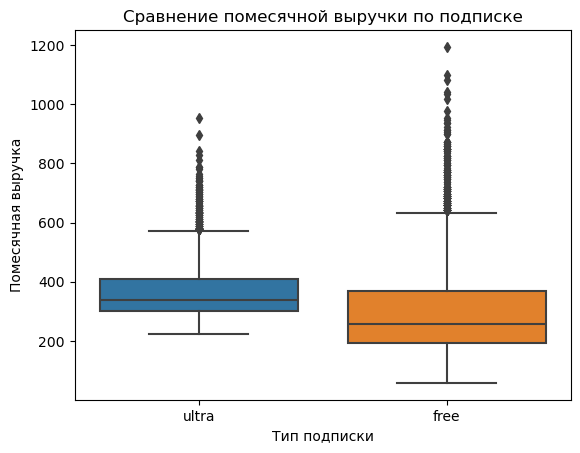

In [58]:
sns.boxplot(x='subscription_type', y='total_revenue', data=agg_df)
plt.title('Сравнение помесячной выручки по подписке')
plt.ylabel('Помесячная выручка')
plt.xlabel('Тип подписки')
plt.show()

### 6.4 
- Нулевая гипотеза (H₀):
Обновление серверов не повлияло на количество обращений — то есть среднее количество обращений не снизилось.
- Альтернативная гипотеза (H₁):
Обновление серверов привело к снижению количества обращений.

Для проверки гипотезы до и после понадобиться paired t-test так как он проверяет, есть ли значимая разница в средних между двумя связанными выборками.

#### Шаг 7. Распределения

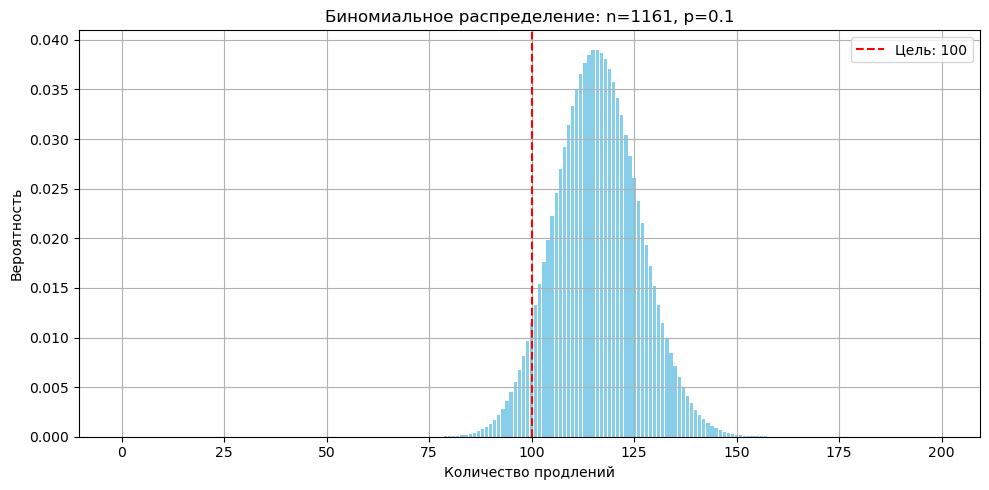

1161

In [59]:
p = 0.10  # вероятность продления подписки
target = 100  # целевое количество продлений
alpha = 0.05  # допустимая вероятность провала

n = target
while binom.cdf(target - 1, n, p) > alpha:
    n += 1

x = np.arange(0, 200)
pmf = binom.pmf(x, n, p)

plt.figure(figsize=(10, 5))
plt.bar(x, pmf, color='skyblue')
plt.axvline(target, color='red', linestyle='--', label=f'Цель: {target}')
plt.title(f'Биномиальное распределение: n={n}, p={p}')
plt.xlabel('Количество продлений')
plt.ylabel('Вероятность')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n

Потребуется 1161 промокодов что бы вероятность не выполнить план составило 5% (100 новых клиентов в конце месяца) 

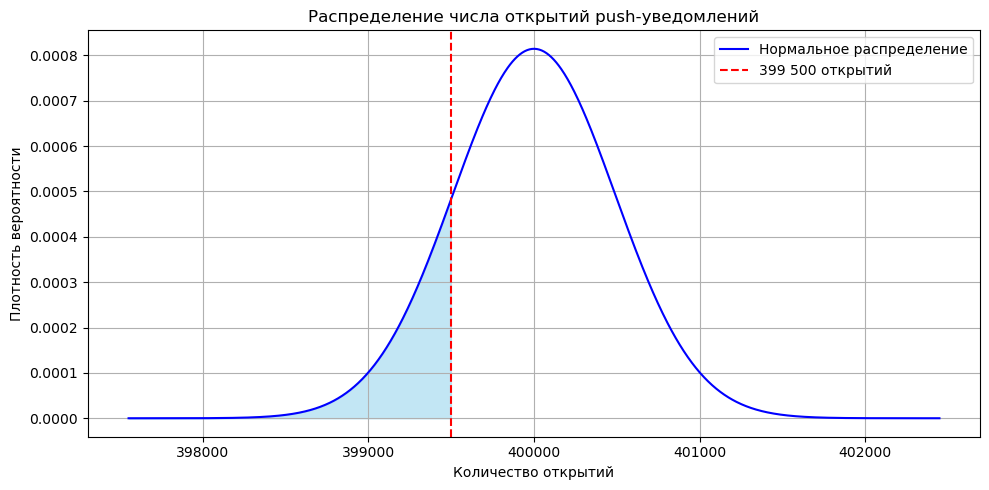

0.15371708296369768

In [60]:
p = 0.40            # вероятность открытия уведомления
n = 1_000_000       # число разосланных уведомлений
x_crit = 399_500    # порог, интересующий отдел (не более 399.5 тыс.)

mu = n * p                      # матожидание
sigma = np.sqrt(n * p * (1 - p))  # стандартное отклонение

z = (x_crit - mu) / sigma
probability = norm.cdf(z)

x_vals = np.linspace(mu - 5*sigma, mu + 5*sigma, 1000)
y_vals = norm.pdf(x_vals, mu, sigma)

plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_vals, label='Нормальное распределение', color='blue')
plt.axvline(x_crit, color='red', linestyle='--', label='399 500 открытий')
plt.fill_between(x_vals, y_vals, where=(x_vals <= x_crit), color='skyblue', alpha=0.5)
plt.title('Распределение числа открытий push-уведомлений')
plt.xlabel('Количество открытий')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

probability


Вероятность того, что push-уведомление откроют не более 399 500 пользователей из 1 миллиона составляет примерно 15.4%.

- Загрузка и предобработка данных.

Был проведен анализ данных поездок клиентов сервиса аренды самокатов GoFast за весь 2021 год. Предоставленные три файла (users_go.csv, rides_go.csv, subscriptions_go.csv) не имели дубликатов и пропусков, кроме файла users_go_data, где были удалены 31 дубликат. В целом сырые данные были хорошо структурированы и не требовали значительных исправлений. 

- Исследовательский анализ данных

1) Установлено 8 основных городов где был представлен сервис аренды самокатов. Самыми популярными из них оказались Пятигорск, Екатеринбург и Ростов-на-Дону. Тем не менее разрыв между городами незначителен.

2) Установлено процентное соотношение между двумя видами клиентов, тех кто оформил подписку (45,6%) и без подписки (54,4%).

3) Определена возрастная структура клиентов сервиса, львиная доля клиентов были в диапазоне от 20 до 30 лет, со средним значением в 25 лет.

4) Выведена гистрограмма описывающая структуру поездок клиентов по расстоянию, определено что клиенты арендуют самокат на короткие до 1.5 км и на длинные дистанции до 5 км. Среднее составило 3 км.

5) Выведена гистограмма описывающая длительность поездок в минутах, среднее значение составило 17 минут.

- Объединение данных

1) Было проведено объединение трех файлов по ID клиентов с целью дальнейшего статистического анализа данных. Из объединенного файла была проведена сортировка по типу подписки (free и ultra). Также был добавлен столбец месяц, с целью подсчет помесячной выручки.

2) Выведена гистограмма описывающая распределение расстояние поездок в обеих группах.

3) Выведена гистограмма описывающая распределение длительности поездок в обеих группах.

- Подсчет выручки

1) Был проведена агрегация данных для суммирования расстояния, количество поездок и суммарное время для каждого пользователя за каждый месяц.

2) Были добавлены столбецы с рассчетом помесячной выручки и общей выручки каждого клиента.

- Проверка гипотез

1) Установлено что клиенты без подписки тратят на поездки в среднем на 2 минуты больше времени, то есть отвергнута нулевая гипотеза что клиенты обеих групп тратят на поездки одинаковое количество времени. 

2) Установлено что клиенты с подпиской проезжают в среднем 3115 метров, что меньше установленного оптимального значения 3130 метров, то есть нулевая гипотеза подтвердилась.

3) Установлено что клиенты с подпиской приносят на 23% больше денег чем клиенты без подписки, 362 рубля против 293 рублей, подтвердилась альтернативная гипотеза что клиенты с подпиской для сервиса выгоднее.

- Вывод:

Проведенный статистический анализ данных поможет менеджерам компании в формировании маркетинговых стратегий и акций с целью увеличения клиентской базы и прибыли. Проведенный анализ также поможет в перерасчетах тарификации и внедрения более гибких тарифов для клиентов с разными потребностями.  